# Qcodes example with Alazar ATS 9360

In [1]:
# import all necessary things
%matplotlib nbagg

import qcodes as qc
import qcodes.instrument.parameter as parameter
import qcodes.instrument_drivers.AlazarTech.ATS9360 as ATSdriver
import qcodes.instrument_drivers.AlazarTech.ATS_acquisition_controllers as ats_contr

User schema at C:\Users\Jens/qcodesrc_schema.json not found.User settings won't be validated


In [2]:
# Command to list all alazar boards connected to the system
ATSdriver.AlazarTech_ATS.find_boards()

[{'system_id': 1,
  'board_id': 1,
  'board_kind': 'ATS9360',
  'max_samples': 4294967294,
  'bits_per_sample': 12}]

# First we create an Alazar Instrument

In [3]:
ats_inst = ATSdriver.AlazarTech_ATS9360(name='Alazar1')
# Print all information about this Alazar card
ats_inst.get_idn()

{'firmware': None,
 'model': 'ATS9360',
 'max_samples': 4294967294,
 'bits_per_sample': 12,
 'serial': '970396',
 'vendor': 'AlazarTech',
 'CPLD_version': '25.16',
 'driver_version': '6.0.3',
 'SDK_version': '6.0.3',
 'latest_cal_date': '25-01-17',
 'memory_size': '4294967294',
 'asopc_type': '1779729248',
 'pcie_link_speed': '0.5GB/s',
 'pcie_link_width': '8'}

Then we instantiate an acquisition controller. In this case we are doing a demodulation. It is expected that more customized  
controllers exists outside the QCoDeS repository. 

The driver defines low lever interaction with the card whereas the role of the controller is to handel the data storage and any post processing of the data.

In [4]:
acquisition_controller = ats_contr.Demodulation_AcquisitionController(name='acquisition_controller', 
                                                                      demodulation_frequency=10e6, 
                                                                      alazar_name='Alazar1')

# Configure the Alazar card. 

Because setting each setting of the card individually  is slow we set all setting as manual parameters and sync them to the card in the end. We can either do this by manually calling sync_settings_to_card or by using the syncing context manager as shown below. The context manager automatically sync at the end of the code block. The Alazar ATS-SDK-Guide http://www.alazartech.com/support/Download%20Files/ATS-SDK-Guide-7.1.4.pdf will be useful for understanding the use and limitations of the parameters given below.

In [5]:
# Configure all settings in the Alazar card
with ats_inst.syncing():    
    ats_inst.clock_source('INTERNAL_CLOCK')
    ats_inst.sample_rate(1_000_000_000)
    ats_inst.clock_edge('CLOCK_EDGE_RISING')
    ats_inst.decimation(1)
    ats_inst.coupling1('DC')
    ats_inst.coupling2('DC')
    ats_inst.channel_range1(.4)
    ats_inst.channel_range2(.4)
    ats_inst.impedance1(50)
    ats_inst.impedance2(50)
    ats_inst.trigger_operation('TRIG_ENGINE_OP_J')
    ats_inst.trigger_engine1('TRIG_ENGINE_J')
    ats_inst.trigger_source1('EXTERNAL')
    ats_inst.trigger_slope1('TRIG_SLOPE_POSITIVE')
    ats_inst.trigger_level1(160)
    ats_inst.trigger_engine2('TRIG_ENGINE_K')
    ats_inst.trigger_source2('DISABLE')
    ats_inst.trigger_slope2('TRIG_SLOPE_POSITIVE')
    ats_inst.trigger_level2(128)
    ats_inst.external_trigger_coupling('DC')
    ats_inst.external_trigger_range('ETR_2V5')
    ats_inst.trigger_delay(0)
    ats_inst.timeout_ticks(0)
    ats_inst.aux_io_mode('AUX_IN_AUXILIARY') # AUX_IN_TRIGGER_ENABLE for seq mode on
    ats_inst.aux_io_param('NONE') # TRIG_SLOPE_POSITIVE for seq mode on

This command is specific to this acquisition controller.
The kwargs provided here are being forwarded to ats_inst.acquire
It's also possible to set the same parameters directly on the card

In [6]:
acquisition_controller.update_acquisitionkwargs(#mode='NPT',
                 samples_per_record=1024,
                 records_per_buffer=70,
                 buffers_per_acquisition=1,
                 #channel_selection='AB',
                 #transfer_offset=0,
                 #external_startcapture='ENABLED',
                 #enable_record_headers='DISABLED',
                 #alloc_buffers='DISABLED',
                 #fifo_only_streaming='DISABLED',
                 #interleave_samples='DISABLED',
                 #get_processed_data='DISABLED',
                 allocated_buffers=1,
                 #buffer_timeout=1000
)

Getting the value of the parameter 'acquisition' of the instrument 'acquisition_controller' 
performes the entire acquisition  protocol. 
This again depends on the specific implementation of the acquisition controller

In [7]:
acquisition_controller.acquisition()

4.502057194410868

As with all other instruements we can capture a snapshot of the instrument

In [8]:
# make a snapshot of the 'ats_inst' instrument
ats_inst.snapshot()

{'functions': {},
 'submodules': {},
 '__class__': 'qcodes.instrument_drivers.AlazarTech.ATS9360.AlazarTech_ATS9360',
 'parameters': {'IDN': {'value': None,
   'ts': None,
   'raw_value': None,
   '__class__': 'qcodes.instrument.parameter.Parameter',
   'full_name': 'Alazar1_IDN',
   'vals': '<Anything>',
   'unit': '',
   'label': 'IDN',
   'post_delay': 0,
   'name': 'IDN',
   'inter_delay': 0,
   'instrument': 'qcodes.instrument_drivers.AlazarTech.ATS9360.AlazarTech_ATS9360',
   'instrument_name': 'Alazar1'},
  'clock_source': {'value': 'INTERNAL_CLOCK',
   'ts': '2018-07-09 13:43:32',
   'raw_value': 1,
   '__class__': 'qcodes.instrument_drivers.AlazarTech.utils.TraceParameter',
   'full_name': 'Alazar1_clock_source',
   'vals': "<Enum: {'EXTERNAL_CLOCK_10MHz_REF', 'INTERNAL_CLOCK', 'FAST_EXTERNAL_CLOCK'}>",
   'unit': '',
   'label': 'Clock Source',
   'post_delay': 0,
   'name': 'clock_source',
   'val_mapping': {'INTERNAL_CLOCK': 1,
    'FAST_EXTERNAL_CLOCK': 2,
    'EXTERNAL_CL

Finally show that this instrument also works within a loop


Started at 2018-07-09 13:43:34
DataSet:
   location = 'data/2018-07-09/#005_AlazarTest_13-43-34'
   <Type>   | <array_id>                         | <array.name> | <array.shape>
   Setpoint | dummy_set                          | dummy        | (50,)
   Measured | acquisition_controller_acquisition | acquisition  | (50,)
Finished at 2018-07-09 13:43:38


<IPython.core.display.Javascript object>


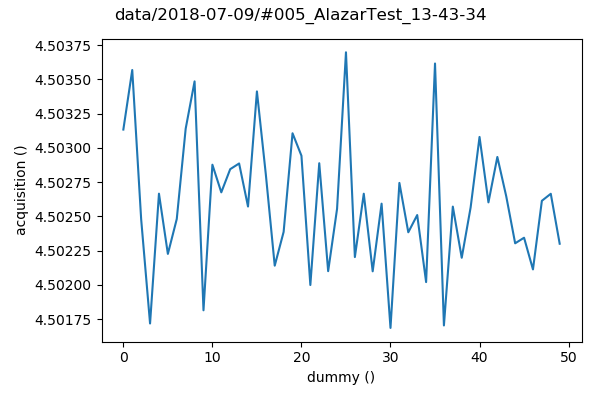

In [9]:
dummy = parameter.ManualParameter(name="dummy")
data = qc.Loop(dummy[0:50:1]).each(acquisition_controller.acquisition).run(name='AlazarTest')
qc.MatPlot(data.acquisition_controller_acquisition)